In [1]:
import numpy as np
import pandas as pd
import time
import os
data_paths = {}
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        data_paths[filename] = os.path.join(dirname, filename)
        print(os.path.join(dirname, filename))

/kaggle/input/hurst-timeseries-assignment/GHE_1.txt
/kaggle/input/hurst-timeseries-assignment/GHE_2.txt
/kaggle/input/hurst-timeseries-assignment/GHE_4.txt
/kaggle/input/hurst-timeseries-assignment/Software_Developer_Python_ML-Phase_1.docx
/kaggle/input/hurst-timeseries-assignment/Input_Data_Non_Param_BootStrap.txt
/kaggle/input/hurst-timeseries-assignment/GHE_3.txt


In [2]:
import numpy as np
import scipy.stats

t1 = time.time()
def ghe_algo1(ghe_path):
    
    with open(ghe_path) as f:
        ghe = [float(line.strip()) for line in f]
    
    S = np.array([ghe])
    theta = 100
    q = 2
    alpha = 1/theta
    
    def calc_wt_ntq_dtq(t, T_maxi):
        # globals: w0, theta, S, q
        wt = [w0 * np.exp(-ti/theta) for ti in t]
        ntq = [abs(S[:,ti+T_maxi] - S[:,ti])**q for ti in t]
        dtq = [abs(S[:,ti])**q for ti in t]
        return wt, ntq, dtq
    
    T_max = np.arange(1,20)
    K = []
    for T_maxi in T_max:
        T = 1000 - T_maxi
        w0 = (1-np.exp(-alpha))/(1-np.exp(-alpha*T))
        T_maxi = T_maxi
        t = np.arange(0,T)
        wt_vec, ntq_vec, dtq_vec = calc_wt_ntq_dtq(t,T_maxi)
        wt_flip = np.flip(wt_vec)
        n_avg = np.dot(wt_flip, ntq_vec)
        d_avg = np.dot(wt_flip, dtq_vec)
        K.append(n_avg/d_avg)  
    
    K = np.array(K).ravel()
    Js = np.arange(5,19)
    slopej = 0
    for j in Js:
        KJ = K[:j]
        TJ = T_max[:j]
        # print(KJ.shape, TJ.shape)
        slopej += scipy.stats.linregress(np.log(TJ), np.log(KJ)).slope

    return slopej/(len(Js) * q)

result = ghe_algo1(data_paths['GHE_1.txt'])
t2 = time.time()
print('Algo 1 for one GHE file: time taken in secs= ', t2-t1)  # 286ms to 300ms for each file
print('\n Result: b_avg/q = ',result)

Algo 1 for one GHE file: time taken in secs=  0.2546873092651367

 Result: b_avg/q =  -0.010203422476123937


## Algo 1

In [3]:
t1 = time.time()
# algo1 without multiprocessing takes around ~ 960ms to 1second on average
algo1_results = [ghe_algo1(data_paths[x]) for x in ['GHE_1.txt', 'GHE_2.txt', 'GHE_3.txt', 'GHE_4.txt']]
t2 = time.time()
print('Algo 1 for 4 GHE files: time taken in secs= ', t2-t1)

Algo 1 for 4 GHE files: time taken in secs=  0.9895098209381104


## Algo 1 (multiprocessing)

In [4]:
import multiprocessing as mp
core_count = mp.cpu_count()
pool = mp.Pool(processes=mp.cpu_count())

t1 = time.time()
# with multiprocessing it takes around ~ 450ms to 500ms on average
algo1_results_mp = pool.map(ghe_algo1,[data_paths[x] for x in ['GHE_1.txt', 'GHE_2.txt','GHE_3.txt', 'GHE_4.txt']]) 
t2 = time.time()
print('Algo 1 for 4 GHE files: time taken in secs = ', t2-t1)
assert(algo1_results == algo1_results_mp) 

Algo 1 for 4 GHE files: time taken in secs =  0.40863633155822754


## Algo 2

Shape:(100, 1501), 
Colums in data:Index(['Symbol', 'Date_1', 'Date_2', 'Date_3', 'Date_4', 'Date_5', 'Date_6',
       'Date_7', 'Date_8', 'Date_9',
       ...
       'Date_1491', 'Date_1492', 'Date_1493', 'Date_1494', 'Date_1495',
       'Date_1496', 'Date_1497', 'Date_1498', 'Date_1499', 'Date_1500'],
      dtype='object', length=1501)

Result: Shape of M_Total= (1000, 100)

Result: Top 5 symbols in decreasing order= ['SYM65' 'SYM55' 'SYM66' 'SYM84' 'SYM61']

Algo 2: Time taken in secs=  0.5884373188018799


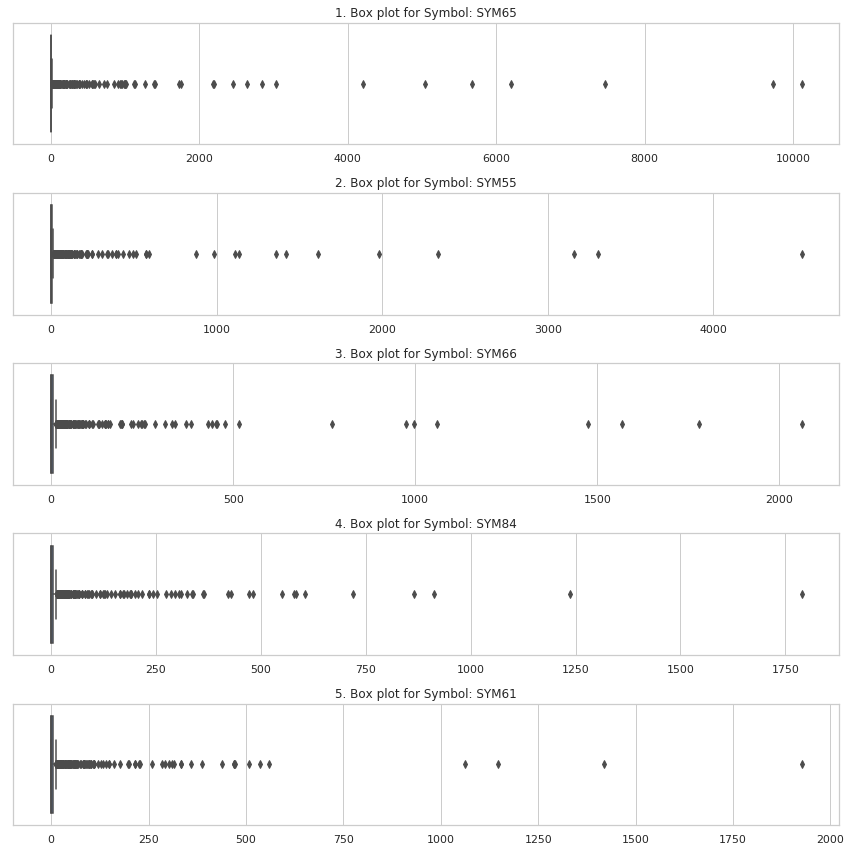

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(5000)

t1 = time.time()

# read the data
df = pd.read_csv(data_paths['Input_Data_Non_Param_BootStrap.txt'], header = [0], sep = '\t')
print('Shape:{}, \nColums in data:{}'.format(df.shape, df.columns))

# define symbols & S
symbols = df.pop('Symbol')
S = df.values

def Calc_M_REV(S):
    B_size = 16
    num_cont_days = 30
    
    # generate random start indices vector of size = B
    randindices = np.random.randint(0, S.shape[1] - num_cont_days, size = B_size)
    
    # intiaize log ratio
    log_ratio = None
    
    # iter over random indices generated & concatenate
    for randindex in randindices:
        log_delta_s = np.log(S[:,randindex + num_cont_days]) - np.log(S[:,randindex])
        try:
            log_ratio = np.concatenate((log_ratio, log_delta_s[np.newaxis,:]))
        except ValueError:
            log_ratio = log_delta_s[np.newaxis,:]

    # calc M
    # print(log_ratio.shape)
    m = np.sum(log_ratio, axis = 0)[np.newaxis,:]
    
    # calc & return M_REV
    m_rev = np.exp(m) - 1
    return m_rev

def Calc_M_Total(num_iter = 1000):
    # intialize M_Total
    M_Total = None
    
    # iter for given num_iter
    for i in range(0,num_iter):
        try:
            M_Total = np.concatenate((M_Total, Calc_M_REV(S)))
        except ValueError:
            M_Total = Calc_M_REV(S)
            
    # return M_Total
    return M_Total

m_total = Calc_M_Total(num_iter = 1000)
print('\nResult: Shape of M_Total= {}'.format(m_total.shape))

# calc m_avg to get the mean importance of each symbol
m_avg = np.mean(m_total, axis = 0)

# get top 5 indices fom the m_avg
top_indices = np.argsort(-m_avg)[:5]

# retrieve the corresponding symbols for the top5 indices 
top_symbols = symbols.values[top_indices]
print('\nResult: Top 5 symbols in decreasing order= {}'.format(top_symbols))
t2 = time.time()
print('\nAlgo 2: Time taken in secs= ', t2-t1)

## Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(12,12))
for i, (indx, label) in enumerate(zip(top_indices, top_symbols)):
    plt.subplot(5, 1, i + 1)
    sns.boxplot(x = m_total[:,indx].ravel())
    plt.title("{}. Box plot for Symbol: {}".format(i+1,label))
    plt.tight_layout()